In [3]:
import torch
import torchvision
 
# 从Torch Hub加载基于COCO datatset预训练的Faster R_CNN模型
Faster_R_CNN_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

import numpy
import scipy
import skimage 
import matplotlib as mt
import matplotlib.image as mpimg 
from skimage import io,transform

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Faster_R_CNN_model.eval()

!pip install torchsummary


import os
# 加载输入的图片
# 用于便利地、全面地格式化模型的输入和输出
folder = "/content/drive/My Drive/test_image/"
list_of_test_data = [f for f in os.listdir(folder) if f.endswith('.jpg')]

inputs = [utils.prepare_input(folder+image_path) for image_path in list_of_test_data]
tensor = utils.prepare_tensor(inputs)
tensor = torch.as_tensor(tensor,device='cpu')
print(tensor.shape)
# 运行Faster R_CNN 网络进行目标检测
with torch.no_grad():
    detections_batch = Faster_R_CNN_model(tensor)
#print(detections_batch[0])

# 对这个输出进行过滤，以更全面的格式只得到合理的检测结果(置信值>40%)
best_results_per_input = detections_batch
for i in range(len(detections_batch)):
  for j in range(len(detections_batch[i]['scores'])):
    if detections_batch[i]['scores'][j] <= 0.4:
      best_results_per_input[i]['boxes'] = numpy.array(best_results_per_input[i]['boxes'][:j])
      best_results_per_input[i]['labels'] = numpy.array(best_results_per_input[i]['labels'][:j])
      best_results_per_input[i]['scores'] = numpy.array(best_results_per_input[i]['scores'][:j])
      break

# 在COCO dataset上训练模型时，我们需要访问该数据集，以便将类id转换为对象名
# 通过此方法会下载一个包含分类名的txt文件
classes_to_labels = utils.get_coco_object_dictionary()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


torch.Size([4, 3, 300, 300])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


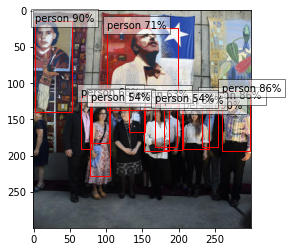

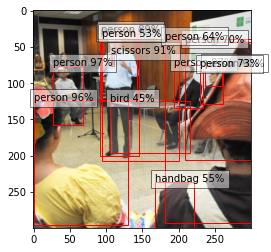

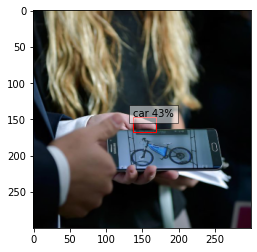

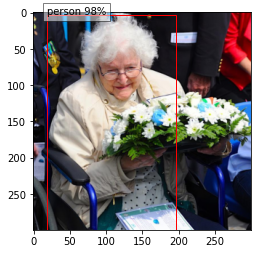

In [4]:
# 可视化输出
from matplotlib import pyplot as plt
import matplotlib.patches as patches
for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # 显示原始的、非规范化的图像
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # 经过检测后  
    bboxes = best_results_per_input[image_idx]['boxes']
    classes = best_results_per_input[image_idx]['labels']
    confidences = best_results_per_input[image_idx]['scores']
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()